# Cartpole



The state and control vectors $\textbf{x}$ and $\textbf{u}$ are defined as follows:

$$
\begin{equation*}
\textbf{x} = \begin{bmatrix}
    x & \dot{x} & \theta & \dot{\theta}
    \end{bmatrix}
\end{equation*}
$$

$$
\begin{equation*}
\textbf{u} = \begin{bmatrix}
    F_{x}
    \end{bmatrix}
\end{equation*}
$$

The goal is to swing the carptole upright:
$$
\begin{equation*}
\textbf{x}_{goal} = \begin{bmatrix}
    0 & 0 & 0 & 0
    \end{bmatrix}
\end{equation*}
$$

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function

In [3]:
import matplotlib.pyplot as plt

In [4]:
import pddp
import pddp.examples

In [5]:
import torch
import numpy as np

In [6]:
DT = 0.1  # Time step (s).
RENDER = False  # Whether to render the environment or not.
N = 25 # Horizon length.

# Disable uncertainty since we are dealing with known dynamics.
ENCODING = pddp.StateEncoding.IGNORE_UNCERTAINTY

In [7]:
cost = pddp.examples.cartpole.CartpoleCost()
model = pddp.examples.cartpole.CartpoleDynamicsModel(DT)
env = pddp.examples.cartpole.CartpoleEnv(dt=DT, render=RENDER)

In [8]:
def plot(Z, U):
    t = np.arange(N + 1) * DT
    X = pddp.utils.encoding.decode_mean(Z, ENCODING).detach().numpy()
    U = U.detach().numpy()

    x = X[:, 0]
    x_dot = X[:, 1]
    theta = np.unwrap(X[:, 2])  # Makes for smoother plots.
    theta_dot = X[:, 3]
    
    plt.figure()
    plt.plot(theta, theta_dot)
    plt.xlabel("Orientation (rad)")
    plt.ylabel("Angular velocity (rad/s)")
    plt.title("Orientation Phase Plot")

    plt.figure()
    plt.plot(t, x)
    plt.xlabel("Time (s)")
    plt.ylabel("Position (m)")
    plt.title("Position path")
    
    plt.figure()
    plt.plot(t, x_dot)
    plt.xlabel("Time (s)")
    plt.ylabel("Velocity (m / s)")
    plt.title("Velocity path")
    
    plt.figure()
    plt.plot(t, theta)
    plt.xlabel("Time (s)")
    plt.ylabel("Orientation (rad)")
    plt.title("Orientation path")

    plt.figure()
    plt.plot(t, theta_dot)
    plt.xlabel("Time (s)")
    plt.ylabel("Angular velocity (rad / s)")
    plt.title("Angular velocity path")
    
    plt.figure()
    plt.plot(t[:-1], U)
    plt.xlabel("Time (s)")
    plt.ylabel("Force (N)")
    plt.title("Action path")
    
    plt.figure()
    plt.plot(J_hist)
    plt.xlabel("Iteration")
    plt.ylabel("Total loss")
    plt.title("Loss path")

In [9]:
def on_iteration(iteration, Z, U, J_opt, accepted, converged):
    J_opt = J_opt.detach().numpy()

    J_hist.append(J_opt)
    info = "CONVERGED" if converged else ("accepted" if accepted else "FAILED")
    final_state = Z[-1].detach().numpy()
    final_state[2] = (final_state[2] + np.pi) % (2 * np.pi) - np.pi
    print("iteration", iteration + 1, info, J_opt, final_state)

In [10]:
controller = pddp.controllers.PDDPController(env, model, cost)

In [11]:
U = 1e-1 * torch.randn(N, model.action_size)

In [12]:
J_hist = []
controller.eval()
Z, U, K = controller.fit(U, encoding=ENCODING, n_iterations=200,
                         on_iteration=on_iteration)

iteration 1 accepted 196.16441 [ 0.11007459  1.0440803  -2.771574   15.426728  ]
iteration 2 accepted 140.29018 [ 5.1804595e-03 -9.6596795e-01  1.5089220e+00  1.0343254e+01]
iteration 3 accepted 111.812004 [-0.23643905 -0.4511518  -0.13551773 -1.671624  ]
iteration 4 accepted 107.12823 [ 0.09029541 -0.08970064 -0.16260876 -0.730093  ]
iteration 5 accepted 103.47274 [ 0.23971742 -0.62539107 -0.5063158  -0.8664801 ]
iteration 6 accepted 98.09687 [ 0.29297677 -0.99682987 -0.90857947 -1.4844291 ]
iteration 7 accepted 95.380486 [ 0.28683022 -0.6731802  -0.86089575 -1.034384  ]
iteration 8 accepted 93.708374 [ 0.19373628 -0.931641   -0.9370152  -1.1049088 ]
iteration 9 accepted 93.2375 [ 0.19468889 -0.95452964 -0.98471415 -1.1708046 ]
iteration 10 accepted 92.686356 [ 0.21719998 -0.8900307  -1.0212418  -1.3497591 ]
iteration 11 accepted 92.35616 [ 0.20593522 -0.84761906 -1.0442978  -1.4263247 ]
iteration 12 accepted 91.91988 [ 0.20798327 -0.7995231  -1.0426623  -1.4721916 ]
iteration 13 acce

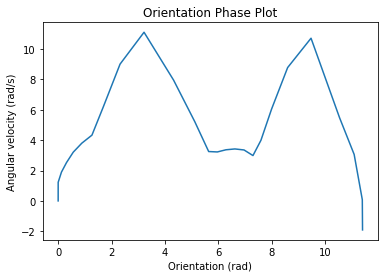

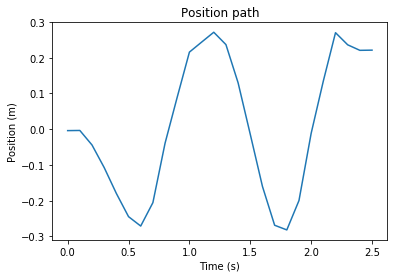

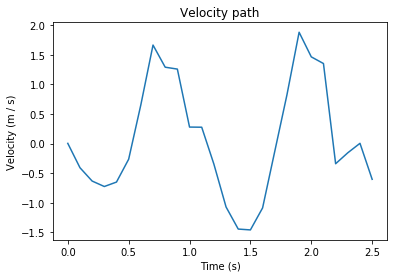

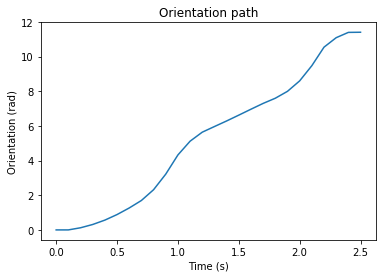

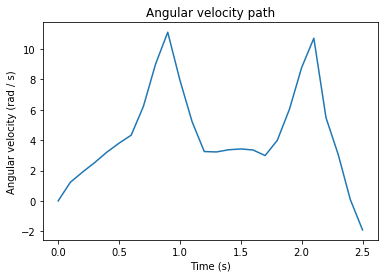

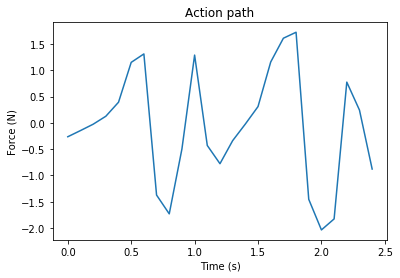

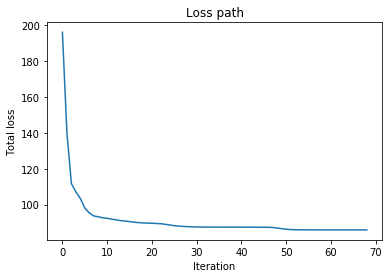

In [13]:
plot(Z, U)

In [14]:
if RENDER:
    # Wait for user interaction before visualizing. 
    _ = input("Press ENTER to continue")

In [15]:
for u in U:
    env.apply(u)

In [16]:
env.close()